# Test 1D: zero velocity, constant T
---

Consider a spherically symmetric model with maximal radius $R$.
Assume no velocity field, so there are no Doppler shifts,
\begin{equation}
    v(r) = 0.
\end{equation}
Assume the temperature to be constant throughout the model, such that the source function is constant throughout the model.
Assume an inverse-square law for the CO abundance,
\begin{equation}
    n_{\text{CO}}(r) = n_{\text{CO}}(r_{\text{in}}) \left(\frac{r_{\text{in}}}{r}\right)^{2} .
\end{equation}

Let $b$ denote the impact parameter, such that $b \in [0, R]$, and $a$ is the distance along the ray, such that $a \in [-\sqrt{R^{2}-b^{2}}, +\sqrt{R^{2}-b^{2}}]$, and such that the radial distance from the origin for each parameter $a$ is given by,
\begin{equation}
r = \sqrt{a^{2}+b^{2}}.
\end{equation}

\begin{align}
\tau_{\text{max}}(b) \ &= \ \chi_{ij} \, \phi(\nu) \, n_{\text{CO}}(r_{\text{in}}) \int_{-\sqrt{R^{2}-b^{2}}}^{+\sqrt{R^{2}-b^{2}}} \text{d}a' \
\frac{r_{\text{in}}^{2}}{a'^{2}+b^{2}} \\
 \ &= \ 2 \chi_{ij} \, \phi(\nu) \, n_{\text{CO}}(r_{\text{in}}) \frac{R_{\text{in}}^{2}}{b} \text{arctan}\left( \frac{\sqrt{R^{2}-b^{2}}}{b} \right)
\end{align}

\begin{align}
I(b) &= I_{\text{bdy}} \, e^{-\tau_{\text{max}}(b)} + \int_{0}^{\tau_{\text{max}}(b)} \text{d}\tau' S \, e^{-\tau'} \\
    &= I_{\text{bdy}} \, e^{-\tau_{\text{max}}(b)} + S \left(1 - e^{-\tau_{\text{max}}(b)}\right)
\end{align}

The integrated intensity then yields
\begin{align}
I(\nu) \ = \ \int_{0}^{R} \text{d}b \ 2 \pi b \, I(b)
\end{align}

In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import torch
plt.rcParams["font.family"] = "serif"

from astropy         import units, constants
from scipy.integrate import quad
from pomme.lines  import Line
from pomme.loss   import Loss
from pomme.model  import TensorModel, SphericalModel
from pomme.utils  import planck

In [2]:
# Line data
lines = [Line('CO', i) for i in range(1)]

# Frequency data
vdiff = 100   # velocity increment size [m/s]
nfreq = 100   # number of frequencies

velocities  = nfreq * vdiff * torch.linspace(-1, +1, nfreq, dtype=torch.float64)
frequencies = [(1.0 + velocities / constants.c.si.value) * line.frequency for line in lines]

You have selected line:
    CO(J=1-0)
Please check the properties that were inferred:
    Frequency         1.152712018e+11  Hz
    Einstein A coeff  7.203000000e-08  1/s
    Molar mass        28.0101          g/mol


/home/frederikd/.local/lib/python3.9/site-packages/astroquery/lamda/core.py:145: UserWarning: The first time a LAMDA function is called, it must assemble a list of valid molecules and URLs.  This list will be cached so future operations will be faster.
  warnings.warn("The first time a LAMDA function is called, it must "


In [5]:
n_elements = 128

r_in  = (1.0e+0 * units.au).si.value
r_out = (1.0e+2 * units.au).si.value

# rs = np.logspace(np.log10(r_in), np.log10(r_out), n_elements)
rs = np.linspace(         r_in ,          r_out , n_elements)

T     = (5.0e+3 * units.K).si.value
T_bdy = (2.7e+2 * units.K).si.value

nCO_in = 1.0e+12

n_CO = nCO_in * (r_in / rs)**2

v_turb = (1.5 * units.km / units.s).si.value

I_bdy = planck(temperature=T_bdy, frequency=frequencies[0])

model = TensorModel(sizes=r_out, shape=n_elements)
# Define and initialise the model variables
model['log_CO'        ] = np.log(n_CO)
model['log_turbulence'] = np.log(v_turb) * np.ones(n_elements)
model['log_T'         ] = np.log(T)
model['log_T_bdy'     ] = np.log(T_bdy)

In [6]:
def get_velocity(model):
    return torch.zeros_like(model['log_CO'])

def get_temperature(model):
    return torch.exp(model['log_T']) * torch.ones_like(model['log_CO'])

def get_abundance(model):
    return torch.exp(model['log_CO'])

def get_turbulence(model):
    return torch.exp(model['log_turbulence'])

def get_boundary_condition(model, frequency, b):
    T_bdy = torch.exp(model['log_T_bdy'])
    # return torch.zeros_like(frequency)
    return planck(temperature=T_bdy, frequency=frequency)
        
smodel = SphericalModel(rs, model, r_star=0.0)
smodel.get_velocity           = get_velocity
smodel.get_abundance          = get_abundance
smodel.get_turbulence         = get_turbulence
smodel.get_temperature        = get_temperature
smodel.get_boundary_condition = get_boundary_condition

In [7]:
eta_ij, chi_ij = lines[0].emissivity_and_opacity_ij(lines[0].LTE_pops(torch.Tensor([T])))
dnu            = lines[0].gaussian_width(torch.exp(model['log_T']), torch.exp(model['log_turbulence'])).mean().item()

S = (eta_ij / chi_ij).item()

def phi(nu):
    return np.exp(-(nu - lines[0].frequency)**2 / dnu**2) / np.sqrt(np.pi) / dnu

def tau_max(b, nu):
    return 2.0 * chi_ij.item() * nCO_in * r_in**2 / b * phi(nu) * np.arctan(np.sqrt((r_out/b)**2 - 1.0))

def I(b, nu):
    # Ib = 0.0
    Ib = planck(temperature=T_bdy, frequency=nu)
    return S + (Ib - S) * np.exp(-tau_max(b, nu))

def integrant(b, nu):
    return 2.0 * np.pi * b * I(b, nu)

def I_int(nu):
    return quad(integrant, 0.0, r_out, args=nu)

Is_test = [I_int(nu)[0] for nu in frequencies[0].tolist()]

In [8]:
Is = smodel.image(lines, frequencies)

100%|██████████| 127/127 [00:00<00:00, 252.64it/s]


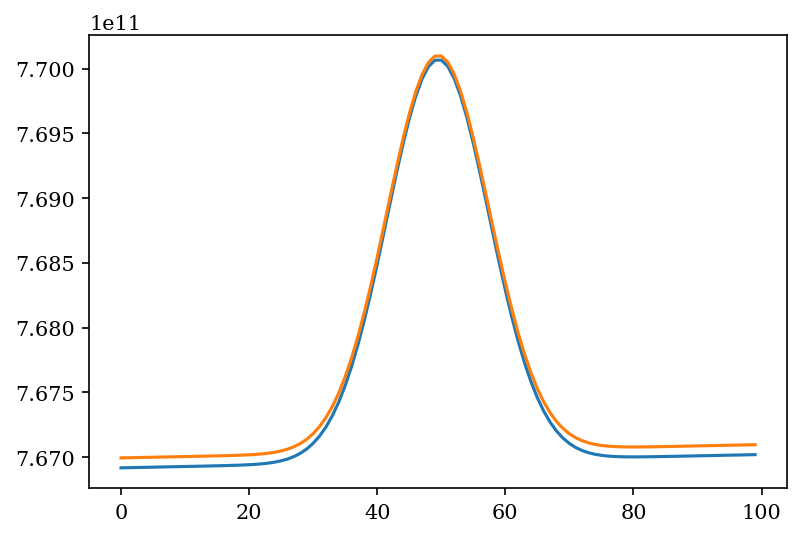

In [9]:
plt.figure(dpi=150)
plt.plot(Is[0].data)
plt.plot(Is_test)
# plt.plot(I_bdy)
# plt.yscale('log')

In [10]:
velocity    = smodel.get_velocity   (smodel.model_1D)
abundance   = smodel.get_abundance  (smodel.model_1D)
temperature = smodel.get_temperature(smodel.model_1D)
turbulence  = smodel.get_turbulence (smodel.model_1D)

i=10

line = lines[0]
freq = torch.Tensor([line.frequency])

I_cen = []
I_cen_test = []

for i in range(smodel.Nb):
    # Get boundary condition at this impact parameter
    img_bdy = smodel.get_boundary_condition(smodel.model_1D, frequency=freq, b=smodel.rs[i])

    # Get intensity at this impact parameter
    I_loc = line.LTE_image_along_last_axis(
        abundance    = abundance  [smodel.idss[i]],
        temperature  = temperature[smodel.idss[i]],
        v_turbulence = turbulence [smodel.idss[i]],
        velocity_los = velocity   [smodel.idss[i]] * smodel.diss[i],
        frequencies  = freq,
        dx           = smodel.dZss[i],
        img_bdy      = img_bdy
    )

    I_cen     .append(I_loc.item())
    I_cen_test.append(I(rs[i], freq))

In [11]:
I_cen

[1.4304405523414697e-15,
 1.2771042743146747e-15,
 1.2198601433708786e-15,
 1.1895392454959463e-15,
 1.170678386626146e-15,
 1.1577892774032186e-15,
 1.1484153349482926e-15,
 1.1412879865267788e-15,
 1.1356846567429246e-15,
 1.1311630958006972e-15,
 1.1274372779014824e-15,
 1.1243139404182669e-15,
 1.1216577637331917e-15,
 1.119371153106372e-15,
 1.117381940488899e-15,
 1.1156356057191472e-15,
 1.1140901902435495e-15,
 1.112712874967185e-15,
 1.11147761933033e-15,
 1.11036349695041e-15,
 1.1093534984519637e-15,
 1.108433655619029e-15,
 1.1075923907641907e-15,
 1.1068200263169775e-15,
 1.1061084102156955e-15,
 1.105450626696161e-15,
 1.104840770454454e-15,
 1.1042737685742272e-15,
 1.1037452388324242e-15,
 1.1032513759975267e-15,
 1.1027888598735349e-15,
 1.1023547803870256e-15,
 1.1019465761421713e-15,
 1.1015619837008354e-15,
 1.1011989954652666e-15,
 1.1008558245077992e-15,
 1.1005308750463728e-15,
 1.100222717535983e-15,
 1.0999300675554233e-15,
 1.099651767831301e-15,
 1.0993867728

/home/frederikd/.conda/envs/magritte/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/frederikd/.conda/envs/magritte/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


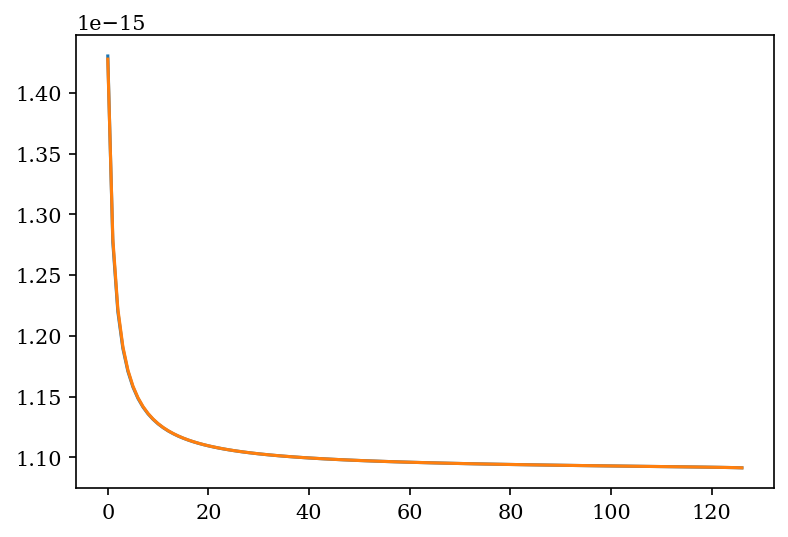

In [12]:
plt.figure(dpi=150)
plt.plot(I_cen)
plt.plot(I_cen_test)

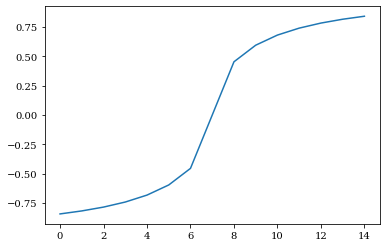

In [122]:
plt.plot(smodel.diss[8])